This strategy focuses on Fair Value Gaps (FVGs) and utilises a variety of technical indicators and confluences to generate buy and sell signals. It incorporates dynamic position sizing and advanced trade management techniques to optimise performance.

# Import modules

In [9]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
from backtesting import Backtest, Strategy
import multiprocessing
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

multiprocessing.set_start_method('fork', force=True)

#were using this code as an excuse to code EVERYTHING, e.g two types of supports , trailing stop vs non trailing , dynamic take profit function vs none

# Class detect FVG

In [10]:
class detect_FVG:
    def __init__(self,
                 df,
                 min_gap_size=1,
                 max_candles=10,
                 lookback_bos=100,
                 range_threshold=0.02,
                 lower_threshold=0.02,
                 upper_threshold=0.6,
                 support_lookback=5,
                 support_tolerance=0.01,
                 support_method="slope"):

        """
            :param df: DataFrame
            :param min_gap_size: The minimum gap size required to consider a new FVG.
            :param max_candles: How many candles after zone test we allow for final validation.
            :param range_threshold: The % threshold for checking proximity in break of structure.
            :param lower_threshold, upper_threshold: For checking if FVG is in an allowed range.
            :param support_lookback: How many bars to look back for support logic.
            :param support_tolerance: Tolerance percentage (e.g. 0.01 = ±1%) around a support price.
            :param support_method: "slope" or "high_low_limit" approach for detecting support candles.
        """


        self.df = df
        self.min_gap_size = min_gap_size
        self.max_candles = max_candles
        self.lookback_bos = lookback_bos
        self.range_threshold = range_threshold
        self.lower_threshold = lower_threshold
        self.upper_threshold = upper_threshold

        self.support_lookback = support_lookback
        self.support_tolerance = support_tolerance
        self.support_method = support_method

        self.fvg_detected_count = 0
        self.fvg_validated_count = 0

            # Arrays/lists for signals
        self.signals = np.zeros(len(df))
        self.active_fvgs = []

        # OPTIONAL: heres another place could of called self.calculate_support()
        # below is intiallising the other columns 

        self.df["signal"] = 0
        self.df["fvg_low"] = np.nan
        self.df["fvg_high"] = np.nan
        self.df["fvg_type"] = None

    def calculate_support_resistance(self):
            """
            Calculates support and resistance levels in self.df:
            - 'is_support_candle': marks bars identified as support
            - 'is_resistance_candle': marks bars identified as resistance
            - 'on_recent_support': checks if the current bar is near a prior support
            - 'on_recent_resistance': checks if the current bar is near a recent resistance
            - option for a sloped base apporach or a local minima/maxima approach, can change when optimsising 
            """

            df = self.df  

            # 1) Mark support and resistance candles
            if self.support_method == "slope":
                # Slope-based approach
                df['ma'] = df['Close'].rolling(window=5).mean()
                df['slope'] = df['ma'].diff()

                df['is_support_candle'] = (
                    (df['slope'].shift(1) < 0) & (df['slope'] > 0)
                )

                df['is_resistance_candle'] = (
                    (df['slope'].shift(1) > 0) & (df['slope'] < 0)
                )

            elif self.support_method == "high_low_limit":
                # Local minima/maxima approach using rolling window
                df['is_support_candle'] = (
                    (df['Low'] <= df['Low'].shift(1).rolling(window=self.support_lookback).min()) &
                    (df['Low'] <= df['Low'].shift(-1).rolling(window=self.support_lookback).min())
                )
                df['is_resistance_candle'] = (
                    (df['High'] >= df['High'].shift(1).rolling(window=self.support_lookback).max()) &
                    (df['High'] >= df['High'].shift(-1).rolling(window=self.support_lookback).max())
                )

            else:
                raise ValueError("Invalid support_method. Use 'slope' or 'high_low_limit'.")

            # 2) Identify if the current bar is near a recent support/ esistance
            def is_near_recent_level(current_value, recent_levels, tolerance_pct):
                
                #Checks if the current value is near any of the recent levels within the given tolerance.
                
                lower_bound = current_value * (1 - tolerance_pct)
                upper_bound = current_value * (1 + tolerance_pct)
                return np.any((recent_levels >= lower_bound) & (recent_levels <= upper_bound))

            # Finds support and resistance levels
            support_prices = df['Low'].where(df['is_support_candle'], np.nan)
            support_indices = np.where(df['is_support_candle'])[0]
            support_lowvals = support_prices.dropna().values  # Extracts actual low values for support candles

            resistance_prices = df['High'].where(df['is_resistance_candle'], np.nan)
            resistance_indices = np.where(df['is_resistance_candle'])[0]
            resistance_highvals = resistance_prices.dropna().values  # Extracts actual high values for resistance candles

            current_lows = df['Low']
            current_highs = df['High']
            on_recent_support = np.zeros(len(df), dtype=bool)
            on_recent_resistance = np.zeros(len(df), dtype=bool)

            lookback = self.support_lookback
            tolerance_pct = self.support_tolerance

            for i in range(len(df)):
                left_index = max(0, i - lookback)

                # Identify recent support and resistance levels within the lookback window
                recent_support_lows = support_lowvals[np.searchsorted(support_indices, left_index, side='left') :
                                                    np.searchsorted(support_indices, i, side='left')]
                
                recent_resistance_highs = resistance_highvals[np.searchsorted(resistance_indices, left_index, side='left') :
                                                            np.searchsorted(resistance_indices, i, side='left')]

                # Check if current values are near support/resistance levels
                if is_near_recent_level(current_lows.iloc[i], recent_support_lows, tolerance_pct):
                    on_recent_support[i] = True

                if is_near_recent_level(current_highs.iloc[i], recent_resistance_highs, tolerance_pct):
                    on_recent_resistance[i] = True

            df['on_recent_support'] = on_recent_support
            df['on_recent_resistance'] = on_recent_resistance

            # Update the dataframe with new columns
            self.df = df

    def run(self):
        """
        Main loop: single pass through df.
        """
        # If one didn't do self.calculate_support() in __init__ 
        # you could do it here, before the loop:
        
        self.calculate_support_resistance()
        self.detect_market_regime()
        
        n_bars = len(self.df)
        for i in range(2, n_bars):
            #  detecting a new bullish FVG at candle i
            self.detect_new_fvg(i)
            # Update and validate all active FVGs with the latest candle i
            self.update_active_fvgs(i)
 
        return self.signals

    def detect_new_fvg(self, i):
        """
        Check if a new bullish or bearish FVG is formed at candle i:
        """

        # Extract candle values
        high_i2 = self.df['High'].iloc[i - 2]
        low_i = self.df['Low'].iloc[i]

        # edited out logging
        #if i < 50:
         #print(f"Bar {i}: gap_size = {low_i - high_i2}, High[i-2]={high_i2}, Low[i]={low_i}")   

        low_i2 = self.df['Low'].iloc[i - 2]
        high_i = self.df['High'].iloc[i]

        fvg_types = [
            {
                "direction": "bullish",
                "fvg_low": high_i2,
                "fvg_high": low_i,
                "gap_size": low_i - high_i2,
                "threshold": high_i2 < low_i,
                "support_key": "on_recent_support"
            },
            {
                "direction": "bearish",
                "fvg_low": high_i,
                "fvg_high": low_i2,
                "gap_size": low_i2 - high_i,
                "threshold": low_i2 > high_i,
                "support_key": "on_recent_resistance"
            }
        ]


        for fvg in fvg_types:
            if fvg["gap_size"] >= self.min_gap_size and fvg["threshold"]:
                #print(f"FVG detected at bar {i}: direction={fvg['direction']}, gap_size={fvg['gap_size']}")  # logging 

                fvg_dict = {
                    "start_idx": i,
                    "fvg_low": fvg["fvg_low"],
                    "fvg_high": fvg["fvg_high"],
                    "zone_tested": False,
                    "validation_candles": 0,
                    "BOS": False,
                    fvg["support_key"]: False,
                    "FVG_is_in_allowed_range": False,
                    "direction": fvg["direction"]
                }

                # Check if it's in allowed range at formation time
                fvg_dict["FVG_is_in_allowed_range"] = self.FVG_is_in_allowed_range(
                    fvg_low=fvg_dict["fvg_low"], fvg_high=fvg_dict["fvg_high"], current_idx=i, direction=fvg_dict['direction']
                )

                # Check break of structure
                fvg_dict["BOS"] = self.is_break_of_structure(
                    current_idx=i, fvg_low=fvg_dict["fvg_low"], fvg_high=fvg_dict['fvg_high'], direction=fvg_dict['direction']
                )

                #  BOS to the DataFrame
                self.df.loc[i, 'BOS'] = fvg_dict["BOS"]

                # Assign support/resistance  
                fvg_dict[fvg["support_key"]] = self.df[fvg["support_key"]].iloc[i]

                if fvg_dict["FVG_is_in_allowed_range"] and (fvg_dict["BOS"] or fvg_dict[fvg["support_key"]]):
                    #print("detect fvg works")
                    self.active_fvgs.append(fvg_dict)
                    self.fvg_detected_count += 1   # To see how many FVGs at this point in the code
                

        
 

    def update_active_fvgs(self, i):
        """
        1) For each active FVG, check if the new candle i "tests" the zone (if not already tested).
        2) If tested, increment validation candle count, check final validation condition.
        3) Remove FVG if validated or expired.
        """
        '''
        could put keep this here for further confrimation
        if not self.df['is_trending'].iloc[i]:
            return  # Skip processing if the market is not trending, need to edit this
        '''

        current_candle = self.df.iloc[i]
        prev_candle = self.df.iloc[i - 1]
        to_remove = []

        for idx, fvg_dict in enumerate(self.active_fvgs):
            direction = fvg_dict["direction"]  
            fvg_low = fvg_dict["fvg_low"]
            fvg_high = fvg_dict["fvg_high"]

            if not fvg_dict['zone_tested']:
                if direction == "bullish":
                # Check if the new candle i "tests" the zone
                    tolerance = 0.005  # to add some leniancy to the support/resistance areas 
                    if (current_candle['Low']*(1 - tolerance) <= fvg_high <= current_candle['High']*(1 + tolerance)):
                        
                        # If bullish close above fvg_high its an immediate test
                        if (current_candle['Close'] > fvg_high
                            and current_candle['Close'] > prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0
                        elif (fvg_low < current_candle['Close'] < fvg_high
                            and current_candle['Close'] < prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0
            
                else:
                    if current_candle['High'] >= fvg_low >= current_candle['Low']:
                        # e.g If new candle closes below the FVG low & is lower than prev close then zone is tested
                        if (current_candle['Close'] < fvg_low
                                and current_candle['Close'] < prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0
                        # Or closes somewhere inside but with some other logic
                        elif (fvg_high > current_candle['Close'] > fvg_low
                            and current_candle['Close'] > prev_candle['Close']):
                            fvg_dict['zone_tested'] = True
                            fvg_dict['validation_candles'] = 0


            else:
                fvg_dict['validation_candles'] += 1

                if direction == "bullish":
                # If close above fvg_high final validation is confirmed and we produce signal
                    if current_candle['Close'] > fvg_dict['fvg_high']:
                        #print(f"Bullish final validation at bar {i}: Close={current_candle['Close']} fvg_high={fvg_dict['fvg_high']}") #this is more logging 
                        # print(f"Bullish signal at bar {i}: Close={current_candle['Close']} > fvg_high={fvg_dict['fvg_high']}")  # to check if theres ever acc bullish signals 
                        self.fvg_validated_count += 1   # <-- New: Count this validated FVG
                        self.signals[i] = 1
                        self.df.iloc[i, self.df.columns.get_loc('signal')]  = 1
                        self.df.iloc[i, self.df.columns.get_loc('fvg_low')] = fvg_low
                        self.df.iloc[i, self.df.columns.get_loc('fvg_high')] = fvg_high
                        self.df.iloc[i, self.df.columns.get_loc('fvg_type')] = 'bullish'
                        to_remove.append(idx)
                    else:
                        # If we exceeded max_candles we discard the potnetial fvg 
                        if fvg_dict['validation_candles'] >= self.max_candles:
                            to_remove.append(idx)
                
                else:
                    if current_candle['Close'] < fvg_low:
                        self.fvg_validated_count += 1   # too see how many FVG we have at this stage 
                        self.signals[i] = -1
                        self.df.iloc[i, self.df.columns.get_loc('signal')] = -1
                        self.df.iloc[i, self.df.columns.get_loc('fvg_low')] = fvg_low
                        self.df.iloc[i, self.df.columns.get_loc('fvg_high')] = fvg_high
                        self.df.iloc[i, self.df.columns.get_loc('fvg_type')] = 'bearish'

                        to_remove.append(idx)
                    else:
                        # If we exceeded max_candles again discard
                        if fvg_dict['validation_candles'] >= self.max_candles:
                            to_remove.append(idx)

        # Remove validated or expired FVGs
        for r_idx in reversed(to_remove):
            self.active_fvgs.pop(r_idx)
    
    def is_break_of_structure(self, current_idx, fvg_low, fvg_high, direction="bullish"):

        """
            Checks if the Close at current_idx breaks above the local swing high
            in the last self.lookback_bos candles, and if fvg_low is near that swing_high.
            fvg_level (float): The FVG price level to compare against.
            Returns:
            bool: True if a break of structure is confirmed, returns False otherwise.
        """
        start_idx = max(0, current_idx - self.lookback_bos)

        if direction == "bullish":
            swing_high = self.df['High'].iloc[start_idx:current_idx].max()
            current_price = self.df['Close'].iloc[current_idx]

            if current_price >= swing_high:
                 # Check proximity of fvg_low to swing_high
                if fvg_low >= swing_high or (swing_high - fvg_low) <= self.range_threshold * swing_high:
                    return True
        elif direction == "bearish":
            swing_low = self.df['Low'].iloc[start_idx:current_idx].min()
            current_price = self.df['Close'].iloc[current_idx]

            if current_price <= swing_low:
                # Check if fvg_level is near swing_low
                if fvg_high <= swing_low or (fvg_high - swing_low) <= self.range_threshold * swing_low:
                    return True
                    
        return False

    def FVG_is_in_allowed_range(self, fvg_low, fvg_high, current_idx, lookback=200, direction="bullish"):
        """
        Check if fvg_low is between [lower_threshold, upper_threshold] of the min-max range in the last lookback period.
        """
        start_idx = max(0, current_idx - lookback)
        recent_df = self.df.iloc[start_idx:current_idx + 1]
        range_high = recent_df['High'].max()
        range_low = recent_df['Low'].min()
        range_height = range_high - range_low
        if range_height <= 0:
                raise ValueError("Range height must be a positive value")

        if direction=="bullish": #higher ones are less significant for bullish
            fvg_position = (fvg_low - range_low) / range_height
            return (self.lower_threshold <= fvg_position <= self.upper_threshold)
        else: #lower ones are less signficant for bearish 
            fvg_position = (range_high - fvg_high) / range_height
            return self.lower_threshold <= fvg_position <= self.upper_threshold

            
    
    
    def detect_market_regime(self,
                             ma_length=50,
                             slope_threshold=0.01,
                             atr_length=14,
                             atr_threshold=1.5,
                             adx_length=14,
                             adx_threshold=25):
        """
        Combine multiple indicators to detect a 'trending' market regime.
        define "trending" if:
            - MA slope is strong
            - Volatility is high
            - ADX is strong
    
        Combine multiple indicators to detect market regime.
        as FVG more prevalaent in trending vs ranging market.
        were not going to opsimsie the contents of detect market regime as we dfont want to overly overfit our backtests 
        
        """
        # 1) Calculating each indicator
        self.calculate_trend(ma_length=ma_length, slope_threshold=slope_threshold)
        self.calculate_volatility(atr_length=atr_length, atr_threshold=atr_threshold)
        self.calculate_adx(adx_length=adx_length, adx_threshold=adx_threshold)

        # 2) Combine them into a  'is_trending' flag
        #    For example, all three conditions must be True:

        self.df['is_bullish_trend'] = (
        (self.df['is_strong_bullish_slope'].astype(int) +
         self.df['high_volatility'].astype(int) +
         self.df['strong_adx'].astype(int)) >= 1
        )

        self.df['is_bearish_trend'] = (
        (self.df['is_strong_bearish_slope'].astype(int) +
         self.df['high_volatility'].astype(int) +
         self.df['strong_adx'].astype(int)) >= 1
        )

        # 3) Set the general market trend flag 
        self.df['is_trending'] = self.df['is_bullish_trend'] | self.df['is_bearish_trend']


    def calculate_trend(self, ma_length=50, slope_threshold=0.01):
        """
        1) Compute a simple moving average and its slope.
        2) Flag if slope is sufficiently large.
        """
        self.df['ma'] = self.df['Close'].rolling(window=ma_length).mean()
        self.df['ma_slope'] = self.df['ma'].diff()
        #  bool: "trend slope" is above threshold
        self.df['is_strong_bullish_slope'] = self.df['ma_slope'] > slope_threshold
        self.df['is_strong_bearish_slope'] = self.df['ma_slope'] < -slope_threshold

    def calculate_volatility(self, atr_length=14, atr_threshold=1.5):
        """
        1) Calculate ATR using pandas_ta.
        2) Compare current ATR to its rolling average to determine if volatility is relatively high
        """
        self.df['ATR'] = ta.atr(
            high=self.df['High'],
            low=self.df['Low'],
            close=self.df['Close'],
            length=atr_length
        )
        # compare ATR to a rolling ATR average * multiplier
        self.df['atr_mean'] = self.df['ATR'].rolling(atr_length).mean()
        self.df['high_volatility'] = (
            self.df['ATR'] > self.df['atr_mean'] * atr_threshold
        )

    def calculate_adx(self, adx_length=14, adx_threshold=25):
        """
        1) Calculate ADX using pandas_ta.
        2) Flag if ADX is above a threshold, indicating a stronger trend.
        """
        adx_df = ta.adx(
            high=self.df['High'],
            low=self.df['Low'],
            close=self.df['Close'],
            length=adx_length
        )
        # 'adx_df' will have columns like ADX_{adx_length}, DMP_{adx_length}, DMN_{adx_length}
        self.df['adx'] = adx_df[f'ADX_{adx_length}']
        self.df['strong_adx'] = self.df['adx'] > adx_threshold

Apply signals function too use the detect fvg fucntion and input the values we want. Also used for ensuring the length of the signal aray is thesame as the dataframe after backtesting.py had edited its length.  

In [11]:
def apply_signals(df, 
                  min_gap_size=1, 
                  max_candles=10,
                  support_lookback=5,
                  support_tolerance=0.01,
                  lower_threshold=0.02,
                  upper_threshold=0.6):
    fvg_sp = detect_FVG(
        df,
        min_gap_size=min_gap_size,
        max_candles=max_candles,
        support_lookback=support_lookback,
        support_tolerance=support_tolerance,
        lower_threshold=lower_threshold,
        upper_threshold=upper_threshold
    )

    signals = fvg_sp.run()

    # <Save FVG counters in the DataFrame's attributes
    df.attrs['fvg_detected_count'] = fvg_sp.fvg_detected_count
    df.attrs['fvg_validated_count'] = fvg_sp.fvg_validated_count

    # If the signals array length is less than the DataFrame index, pad with zeros.
    if len(signals) < len(df.index):
        pad_length = len(df.index) - len(signals)
        signals = np.concatenate([signals, np.zeros(pad_length)])
    # Alternatively, if it is longer than the index, truncate it.
    elif len(signals) > len(df.index):
        signals = signals[:len(df.index)]
    return pd.Series(signals, index=df.index)


# Class Mystrat
This class includes the trading logic and the open position management 

In [12]:
class MyStrat(Strategy):
    min_gap_size= 1 
    max_candles= 10
    support_lookback= 5
    support_tolerance= 0.01
    lower_threshold = 0.02
    upper_threshold = 0.6

    def init(self):
        super().init()
        self.signal1 = self.I(self.calculate_signal)
    
    def get_latest_fvg(self):
        """Return the fvg_low and fvg_high from the most recent bar with a valid FVG signal."""
        df = self.data.df
        valid = df['fvg_type'].notna()
        if valid.any():
            last_valid_idx = df[valid].index[-1]
            fvg_low = df.loc[last_valid_idx, 'fvg_low']
            fvg_high = df.loc[last_valid_idx, 'fvg_high']
            return fvg_low, fvg_high
        return None, None

    def calculate_signal(self):
    # Compute the signals using the full DataFrame stored in self.data.df
        s = apply_signals(
            df=self.data.df, 
            min_gap_size = self.min_gap_size,
            max_candles = self.max_candles,
            support_lookback = self.support_lookback,
            support_tolerance = self.support_tolerance,
            lower_threshold=self.lower_threshold,
            upper_threshold=self.upper_threshold
        )
        # Trim the signals to match the number of bars in the Backtest data.
        # (Backtesting has already dropped some rows, so len(self.data) is the trimmed length.)
        self.fvg_detected_count = self.data.df.attrs.get('fvg_detected_count', 0)
        self.fvg_validated_count = self.data.df.attrs.get('fvg_validated_count', 0)

        return s.iloc[-len(self.data):].values

    def determine_position_size(self, i):
       """
       Dynamically allocate position size based on confluence factors.
       Returns position size fraction (e.g., 0.1 for 10%, 0.2 for 20% of account).
       """
       confluence_score = 0

       if self.data.df['on_recent_support'].iloc[i]:
           confluence_score += 1  # each adds confidence
       else:
           if self.data.df['on_recent_resistance'].iloc[i]:
               confluence_score += 1

       if self.data.df['BOS'].iloc[i]: 
           confluence_score += 1  

       if self.data.df['is_trending'].iloc[i]: 
           confluence_score += 1  

       # Define position size mapping in a dict
       position_sizes = {1: 0.2, 2: 0.4, 3: 0.5}
       
       # Default to minimum size if no confluences
       return position_sizes.get(confluence_score, 0.1)

    def next(self):
        super().next()
        current_price = self.data.Close[-1]
        last_signal = self.signal1[-1]  # Should be 1 for bullish and -1 for bearish.
        pos_size = self.determine_position_size(-1)

        # If there is no open position, try to enter a new trade:
        if not self.position:
            # Retrieve the most recent valid FVG info:
            fvg_low, fvg_high = self.get_latest_fvg()
            if fvg_low is None or pd.isna(fvg_low) or pd.isna(fvg_high):
                # No valid FVG information found, so do nothing.
                return

            # Bullish Trade Logic 
            if last_signal == 1:
                # For a long trade we want SL < current_price.
                # Use the captured fvg_low from when the signal was generated.
                sl_price = fvg_low * 0.99  
                # If the current price is below (or too close to) the SL, skip the trade.
                if current_price <= sl_price:
                    #print("Long trade skipped: current price (%.2f) is not above computed SL (%.2f)." % (current_price, sl_price))
                    return

                risk = current_price - sl_price
                partial_tp_price = current_price + 1.5 * risk

                # Store the trade info (so that we can later reference the same FVG data)
                self.trade_info = {
                    "initial_sl": sl_price,
                    "partial_tp_price": partial_tp_price,
                    "remaining_position_sl": sl_price,
                    "partial_taken": False,
                    "fvg_low": fvg_low,
                    "fvg_high": fvg_high,
                    "entry_price": current_price
                }
                # Place a buy order with valid SL 
                self.buy(sl=sl_price, size=pos_size)

            # Bearish Trade Logic 
            elif last_signal == -1:
                # For a short trade, we expect current_price < SL .
                sl_price = fvg_high * 1.01
                if current_price >= sl_price:
                    #print("Short trade skipped: current price (%.2f) is not below computed SL (%.2f)." % (current_price, sl_price))
                    return

                risk = sl_price - current_price
                partial_tp_price = current_price - 1.5 * risk

                self.trade_info = {
                    "initial_sl": sl_price,
                    "partial_tp_price": partial_tp_price,
                    "remaining_position_sl": sl_price,
                    "partial_taken": False,
                    "fvg_low": fvg_low,
                    "fvg_high": fvg_high,
                    "entry_price": current_price
                }
                self.sell(sl=sl_price, size=pos_size)
            
                
        else:
            ####### MANAGE AN OPEN POSITION ########
            info = self.trade_info
            entry         = info["entry_price"]
            initial_sl    = info["initial_sl"]
            partial_tp    = info["partial_tp_price"]
            partial_taken = info["partial_taken"]
            remaining_sl  = info["remaining_position_sl"]
            pos_size = abs(self.position.size)
            trail_atr_mult = 1.0
            current_atr = self.data.ATR[-1]

            ##### LONG POSITION MANAGEMENT ###

            if self.position.size > 0:
            # Check partial TP
                if not partial_taken and (current_price >= partial_tp):
                    pos_size = abs(self.position.size)
                    # need to see if we're dealing with fractional or whole units
                    if pos_size < 1:
                        half_size = pos_size / 2.0
                        #print(f"Long partial exit (fraction): pos_size = {pos_size}, half_size = {half_size}")
                        self.sell(size=half_size)
                        info["partial_taken"] = True
                    else:
                        half_size = int(round(pos_size / 2.0))
                        #print(f"Long partial exit (integer): pos_size = {pos_size}, half_size = {half_size}")
                        # Make sure half_size is at least 1
                        if half_size >= 1:
                            self.sell(size=half_size)
                            info["partial_taken"] = True
                        else:
                            print("Invalid partial exit size computed:", half_size)


                # If partial is taken, start trailing the remaining half
                if info["partial_taken"]:
                    new_sl = current_price - trail_atr_mult * current_atr
                    # Only move SL upward
                    if new_sl > remaining_sl:
                        info["remaining_position_sl"] = new_sl

                # If we drop below trailing SL, close everything
                if current_price < info["remaining_position_sl"]:
                    self.position.close()

        ###3  SHORT POSITION MANAGEMENT ###
            elif self.position.size < 0:
                # Check partial TP 
                if not partial_taken and (current_price <= partial_tp):
                    pos_size = abs(self.position.size)
                    if pos_size < 1:
                        half_size = pos_size / 2.0
                        #print(f"Short partial exit (fraction): pos_size = {pos_size}, half_size = {half_size}")
                        self.buy(size=half_size)
                        info["partial_taken"] = True
                    else:
                        half_size = int(round(pos_size / 2.0))
                        #print(f"Short partial exit (integer): pos_size = {pos_size}, half_size = {half_size}")
                        if half_size >= 1:
                            self.buy(size=half_size)
                            info["partial_taken"] = True
                        else:
                            print("Invalid partial exit size computed:", half_size)


                # If partial is taken, start trailing the remaining half
                if info["partial_taken"]:
                    new_sl = current_price + trail_atr_mult * current_atr
                    # Only move SL downward
                    if new_sl < remaining_sl:
                        info["remaining_position_sl"] = new_sl

                # If price rises above the trailing SL for a short, close everything 
                if current_price > info["remaining_position_sl"]:
                    self.position.close()

In [13]:
## Backtest for multiple tickers 

In [14]:
def run_backtest_for_ticker(ticker, start='2024-01-01', end='2025-01-01', inerval='1d'):
    print(f"\n=== Backtesting {ticker} ===")
    df = yf.download(tickers=ticker, start=start, end=end, interval='1d')
    if df.empty:
        print(f"No data for {ticker}")
        return None
    
    # Standardise the columns like we do in our other codes 
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(col).strip() for col in df.columns]
    df.columns = [col.split(' ')[0] for col in df.columns]

    #  compute ATR  (14 is abitary )
    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
    
    # Indicators
    df["signal"]   = 0
    df["fvg_low"]  = np.nan
    df["fvg_high"] = np.nan
    df["fvg_type"] = None
    df["BOS"]      = False
        
    # Backtest
    bt = Backtest(df, MyStrat, cash=10000, margin=1, commission=0.001) 
    stats = bt.optimize(
       min_gap_size=[0.1, 0.5, 1],
       lower_threshold=[0.01, 0.02],
       upper_threshold=[0.6, 0.7, 0.9],
       support_lookback=[2, 5, 10],
       support_tolerance=[0.01, 0.05, 0.1],
       maximize='Return [%]',
    )
    
    return (ticker, stats, bt)

###############################################################################
# 3. Run for multiple tickers
tickers = ["AAPL", "AMZN", "TSLA", "NVDA"]
results = []

for tk in tickers:
    out = run_backtest_for_ticker(tk)
    if out is not None:
        results.append(out)

if not results:
    print("No successful backtests to display.")

[*********************100%***********************]  1 of 1 completed


=== Backtesting AAPL ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting AMZN ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting TSLA ===



[*********************100%***********************]  1 of 1 completed


=== Backtesting NVDA ===


# Plotting graphs,tables and organsing results


===== AAPL results =====
Start                     2024-01-02 00:00...
End                       2024-12-31 00:00...
Duration                    364 days 00:00:00
Exposure Time [%]                    32.53968
Equity Final [$]                  10390.36005
Equity Peak [$]                   10467.28014
Return [%]                             3.9036
Buy & Hold Return [%]                 34.8955
Return (Ann.) [%]                      3.9036
Volatility (Ann.) [%]                  4.8736
CAGR [%]                              2.68653
Sharpe Ratio                          0.80097
Sortino Ratio                         1.48724
Calmar Ratio                          0.95544
Max. Drawdown [%]                    -4.08565
Avg. Drawdown [%]                    -1.24944
Max. Drawdown Duration      177 days 00:00:00
Avg. Drawdown Duration       70 days 00:00:00
# Trades                                   14
Win Rate [%]                             50.0
Best Trade [%]                        9.34519
Worst Tr

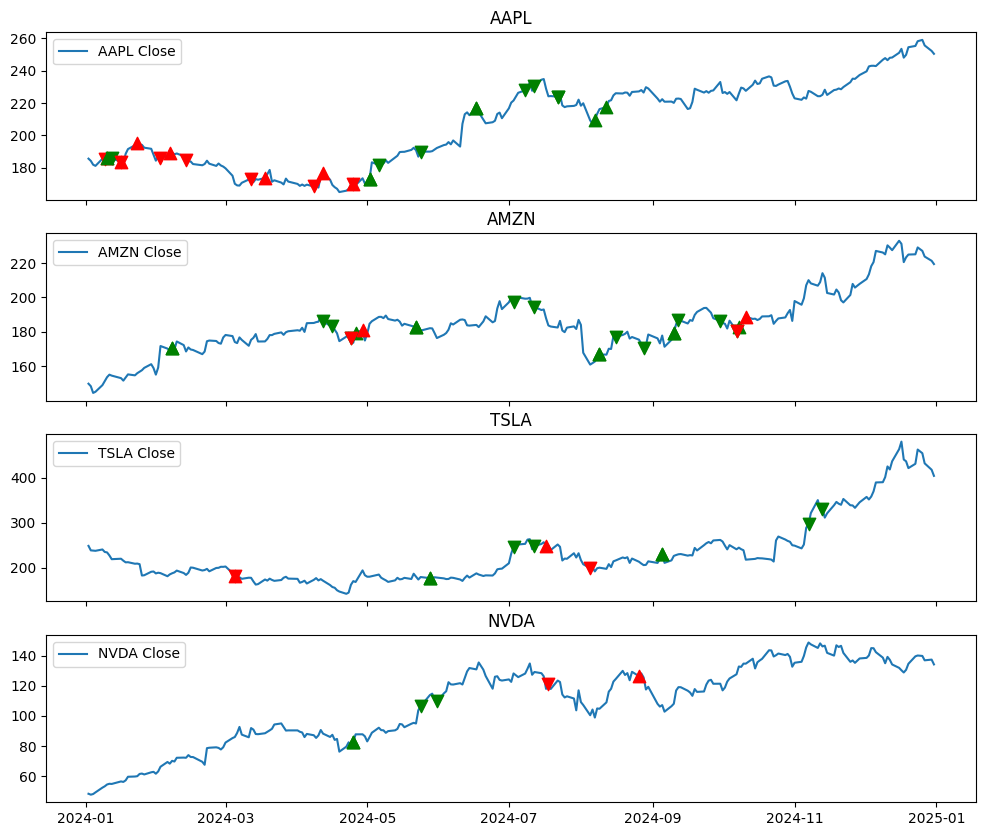

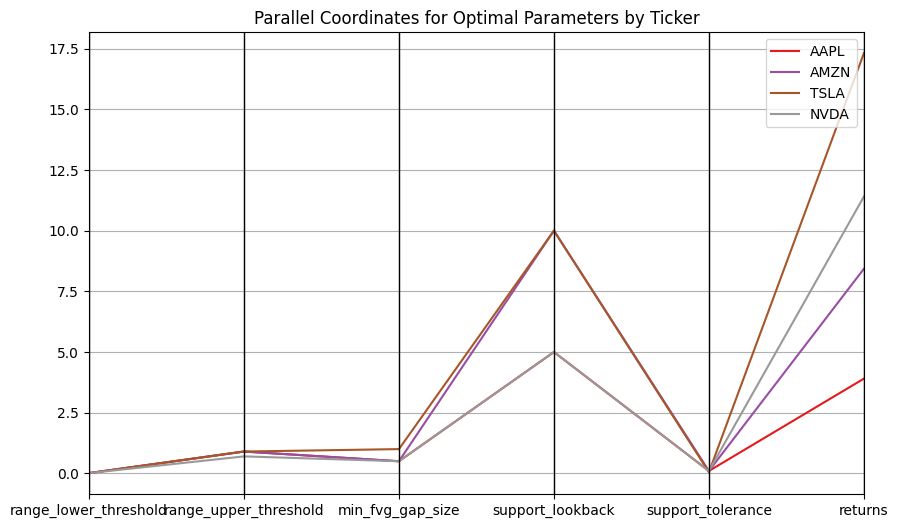

In [16]:
# 4. Plot each ticker in one figure (subplots)
###############################################################################
fig, axes = plt.subplots(len(results), 1, figsize=(12, 10), sharex=True)
if len(results) == 1:
    axes = [axes]  # So we can iterate the same way

for ax, (ticker, stats, bt) in zip(axes, results):
    # Print the stats
    print(f"\n===== {ticker} results =====")
    print(stats)
    print("Optimal Parameters:")
    print(f"  Min gap size:        {stats._strategy.min_gap_size}")
    print(f"  Lower Threshold:       {stats._strategy.lower_threshold}")
    print(f"  Upper Threshold:       {stats._strategy.upper_threshold}")
    print(f"  support/resistance lookback:       {stats._strategy.support_lookback}")
    print(f"  support/resistance tolerance: {stats._strategy.support_tolerance}")

    
    df = bt._data
    ax.plot(df.index, df['Close'], label=f"{ticker} Close")
    ax.set_title(ticker)
    ax.legend() #legend is a key on a plot

    # Mark trades
    for i, row in stats._trades.iterrows():
        entry_bar = int(row['EntryBar'])
        exit_bar = int(row['ExitBar'])
        entry_time = df.index[entry_bar]
        exit_time = df.index[exit_bar]
        entry_price = df['Close'].iloc[entry_bar]
        exit_price = df['Close'].iloc[exit_bar]

        color = 'green' if row['PnL'] > 0 else 'red'
        if row['Size'] > 0:
            # Long trade
            ax.scatter(entry_time, entry_price, marker='^', color=color, s=80, zorder=5)
            ax.scatter(exit_time, exit_price, marker='v', color=color, s=80, zorder=5)
        else:
            # Short trade
            ax.scatter(entry_time, entry_price, marker='v', color=color, s=80, zorder=5)
            ax.scatter(exit_time, exit_price, marker='^', color=color, s=80, zorder=5)


# 5. Gather all optimal params and compute means, medians, etc.
###############################################################################
param_results = {
    "min_gap_size": [],
    "upper_threshold": [],
    "lower_threshold": [],
    "support_lookback": [],
    "support_tolerance": [],
    "returns": []
}

for (ticker, stats, bt) in results:
    param_results["min_gap_size"].append(stats._strategy.min_gap_size)
    param_results["upper_threshold"].append(stats._strategy.upper_threshold)
    param_results["lower_threshold"].append(stats._strategy.lower_threshold)
    param_results["support_lookback"].append(stats._strategy.support_lookback)
    param_results["support_tolerance"].append(stats._strategy.support_tolerance)
    param_results["returns"].append(stats["Return [%]"])

print("\n===== Averages, Medians, Weighted Averages =====") #K and V stands for key and value of dict 
if len(param_results["returns"]) > 0:
    # Averages
    averages = {k: np.mean(param_results[k]) for k in param_results if k != "returns"}
    for k, v in averages.items():
        print(f"Mean {k}: {v:.4f}")
    
    # Medians
    medians = {k: np.median(param_results[k]) for k in param_results if k != "returns"}
    for k, v in medians.items():
        print(f"Median {k}: {v:.4f}")
    
    # Weighted by returns
    weights = np.array(param_results["returns"]) / np.sum(param_results["returns"])
    weighted_averages = {
        k: np.average(param_results[k], weights=weights) 
        for k in param_results if k != "returns"
    }
    for k, v in weighted_averages.items():
        print(f"Weighted {k}: {v:.4f}")
else:
    print("No data to compute averages. Possibly all tickers failed.")

#Parallel Coordinate plot

data_list = []
for (ticker, stats, bt) in results:
    data_list.append({
        "Ticker": ticker,
        "range_lower_threshold": stats._strategy.lower_threshold,
        "range_upper_threshold": stats._strategy.upper_threshold,
        "min_fvg_gap_size": stats._strategy.min_gap_size,
        "support_lookback": stats._strategy.support_lookback,
        "support_tolerance": stats._strategy.support_tolerance,
        "returns": stats["Return [%]"]
    })

df_params = pd.DataFrame(data_list)
print("\n==== df_params (for parallel coordinates) ====")
print(df_params)

# Make sure df_params is not empty before plotting
if not df_params.empty:
    plt.figure(figsize=(10, 6))
    parallel_coordinates(
        df_params,
        class_column='Ticker',
        cols=["range_lower_threshold","range_upper_threshold","min_fvg_gap_size","support_lookback","support_tolerance","returns"],
        colormap=plt.get_cmap("Set1")
    )
    plt.title("Parallel Coordinates for Optimal Parameters by Ticker")
    plt.grid(True)
else:
    print("df_params is empty, so no parallel coordinates plot can be drawn.")

#  Summary Table for FVG and Trade Counts
summary_list = []
for ticker, stats, bt in results:
    # Retrieve the FVG counters saved in the DataFrame attributes:
    fvg_detected = stats._strategy.fvg_detected_count
    fvg_validated = stats._strategy.fvg_validated_count
    
    # Get trades DataFrame and count long/short trades:
    trades_df = stats._trades
    trades_long = trades_df[trades_df['Size'] > 0].shape[0]
    trades_short = trades_df[trades_df['Size'] < 0].shape[0]
    trades_total = trades_df.shape[0]
    
    summary_list.append({
        'Ticker': ticker,
        'FVG Detected': fvg_detected,
        'FVG Validated': fvg_validated,
        'Long Trades': trades_long,
        'Short Trades': trades_short,
        'Total Trades': trades_total
    })

summary_df = pd.DataFrame(summary_list)
print("\n===== Summary Table for FVG and Trades =====")
print(summary_df.to_string(index=False))


# Calculate strategy returns 
strategy_returns = []
for ticker, stats, bt in results:
    ret = stats["Return [%]"]
    strategy_returns.append({"Ticker": ticker, "Strategy Return (%)": ret})

strategy_returns_df = pd.DataFrame(strategy_returns)

# Calculate buy & hold returns 
buy_hold_returns = []
for ticker, stats, bt in results:
    df = bt._data.sort_index()
    bh_return = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100
    buy_hold_returns.append({"Ticker": ticker, "Buy & Hold Return (%)": bh_return})

buy_hold_returns_df = pd.DataFrame(buy_hold_returns)

# Strategy vs. Buy & Hold Comparison 
comparison_df = pd.merge(strategy_returns_df, buy_hold_returns_df, on="Ticker")
print("\n===== Strategy vs. Buy & Hold Comparison =====")
print(comparison_df.to_string(index=False))

# Compute averages
avg_strategy_return = strategy_returns_df["Strategy Return (%)"].mean()
avg_buy_hold_return = buy_hold_returns_df["Buy & Hold Return (%)"].mean()
print(f"\nAverage Strategy Return: {avg_strategy_return:.2f}%")
print(f"Average Buy & Hold Return: {avg_buy_hold_return:.2f}%")

#  comparison message
if avg_strategy_return > avg_buy_hold_return:
    print("Your strategy outperformed the Buy & Hold benchmark.")
else:
    print("Buy & Hold benchmark outperformed your strategy.")


#Plot all graphs
plt.show()